In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

data_path = "data/features/synthbuster/standard"
suffix = "features/extraction_params/train_test/features_RGB.csv"
dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

In [4]:
datasets_train = {
    "dalle2": dalle2,
    "dalle3": dalle3,
    "firefly": firefly,
    "glide": glide,
    "midjourney": midjourney,
    "sd_1_3": sd_1_3,
    "sd_1_4": sd_1_4,
    "sd_2": sd_2,
    "sd_xl": sd_xl,
}

dir_names = {
    "dalle2": "dalle2",
    "dalle3": "dalle3",
    "firefly": "firefly",
    "glide": "glide",
    "midjourney": "midjourney-v5",
    "sd_1_3": "stable-diffusion-1-3",
    "sd_1_4": "stable-diffusion-1-4",
    "sd_2": "stable-diffusion-2",
    "sd_xl": "stable-diffusion-xl",
}

In [5]:
jpg_path = "data/features/synthbuster_jpg/jpg_quality_80"
gauss_path = "data/features/synthbuster_gauss/sigma_2"
for dataset_name, dataset in datasets_train.items():
    datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], 
                                              img,
                                              pd.read_csv(os.path.join(jpg_path, dir_names[dataset_name], suffix), index_col=0),
                                              pd.read_csv(os.path.join(jpg_path, "img", suffix), index_col=0),
                                              pd.read_csv(os.path.join(gauss_path, dir_names[dataset_name], suffix), index_col=0),
                                              pd.read_csv(os.path.join(gauss_path, "img", suffix), index_col=0)])

## Data preparation

In [6]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [7]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [8]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}
X_test = {}

y_train = {}
y_val = {}
y_test = {}

Image_train = {}
Image_val = {}
Image_test = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    # get train, val and test sets
    X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    Image_test[key] = X_test[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)
    X_test[key] = X_test[key].drop('Image', axis=1)
    
# create dataset combining all train sets
X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

# create dataset combining all val sets
X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

# create dataset combining all test sets
X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

X_train['combined'] = X_train_all
y_train['combined'] = y_train_all

X_val['combined'] = X_val_all
y_val['combined'] = y_val_all

X_test['combined'] = X_test_all
y_test['combined'] = y_test_all

### Scale the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9984375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9924479166666667


Training set: dalle3

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99921875


Training set: firefly

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9989583333333333
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99296875


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9989583333333333
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9932291666666667


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9984375
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9908854166666666


Training set: sd_1_3

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9979166666666667


Training set: sd_1_4

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9997395833333333
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.99765625


Training set: sd_2

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9979166666666667


Training set: sd_xl

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9994791666666667
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9979166666666667


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9985243055555556
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9858217592592593
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9830150462962963


## Evaluation

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

### Validation data

In [12]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9845
Recall: 0.9844
MCC: 0.9688

Model: LinearDiscriminantAnalysis
Accuracy: 0.9656
F1: 0.9656
Precision: 0.9658
Recall: 0.9656
MCC: 0.9314

Model: RandomForestClassifier
Accuracy: 0.9583
F1: 0.9583
Precision: 0.9585
Recall: 0.9583
MCC: 0.9168

Model: LinearSVC
Accuracy: 0.9677
F1: 0.9677
Precision: 0.9678
Recall: 0.9677
MCC: 0.9355


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7948
F1: 0.7883
Precision: 0.8406
Recall: 0.7948
MCC: 0.6347

Model: LinearDiscriminantAnalysis
Accuracy: 0.8510
F1: 0.8496
Precision: 0.8676
Recall: 0.8510
MCC: 0.7188

Model: RandomForestClassifier
Accuracy: 0.7708
F1: 0.7638
Precision: 0.8115
Recall: 0.7708
MCC: 0.5819

Model: LinearSVC
Accuracy: 0.9094
F1: 0.9091
Precision: 0.9167
Recall: 0.9094
MCC: 0.8261


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

In [13]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


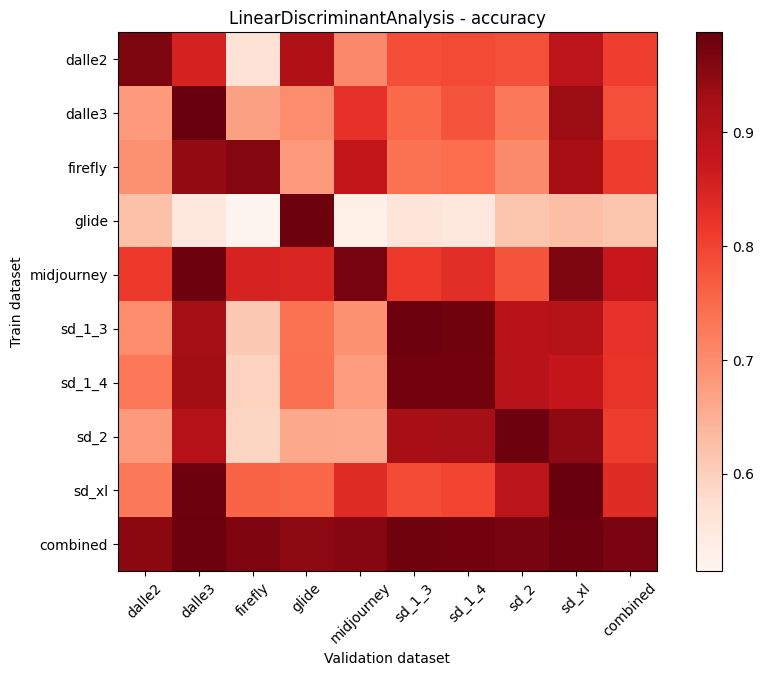

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.965625,0.851042,0.567708,0.910417,0.705208,0.785417,0.791667,0.783333,0.890625,0.805671
dalle3,0.679167,0.987500,0.670833,0.698958,0.825000,0.752083,0.778125,0.729167,0.936458,0.784144
firefly,0.693750,0.941667,0.958333,0.679167,0.881250,0.737500,0.746875,0.704167,0.922917,0.807292
glide,0.622917,0.552083,0.514583,0.979167,0.532292,0.558333,0.550000,0.617708,0.627083,0.617130
midjourney,0.812500,0.979167,0.848958,0.844792,0.969792,0.813542,0.832292,0.777083,0.965625,0.871528
sd_1_3,0.698958,0.927083,0.610417,0.736458,0.692708,0.980208,0.978125,0.896875,0.901042,0.824653
sd_1_4,0.731250,0.930208,0.594792,0.740625,0.678125,0.975000,0.975000,0.900000,0.877083,0.822454
sd_2,0.680208,0.903125,0.590625,0.659375,0.658333,0.923958,0.927083,0.979167,0.946875,0.807639
sd_xl,0.727083,0.979167,0.757292,0.753125,0.835417,0.788542,0.795833,0.892708,0.985417,0.834954


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.965625,0.851042,0.567708,0.910417,0.705208,0.785417,0.791667,0.783333,0.890625,0.805671
dalle3,0.679167,0.987500,0.670833,0.698958,0.825000,0.752083,0.778125,0.729167,0.936458,0.784144
firefly,0.693750,0.941667,0.958333,0.679167,0.881250,0.737500,0.746875,0.704167,0.922917,0.807292
glide,0.622917,0.552083,0.514583,0.979167,0.532292,0.558333,0.550000,0.617708,0.627083,0.617130
midjourney,0.812500,0.979167,0.848958,0.844792,0.969792,0.813542,0.832292,0.777083,0.965625,0.871528
sd_1_3,0.698958,0.927083,0.610417,0.736458,0.692708,0.980208,0.978125,0.896875,0.901042,0.824653
sd_1_4,0.731250,0.930208,0.594792,0.740625,0.678125,0.975000,0.975000,0.900000,0.877083,0.822454
sd_2,0.680208,0.903125,0.590625,0.659375,0.658333,0.923958,0.927083,0.979167,0.946875,0.807639
sd_xl,0.727083,0.979167,0.757292,0.753125,0.835417,0.788542,0.795833,0.892708,0.985417,0.834954


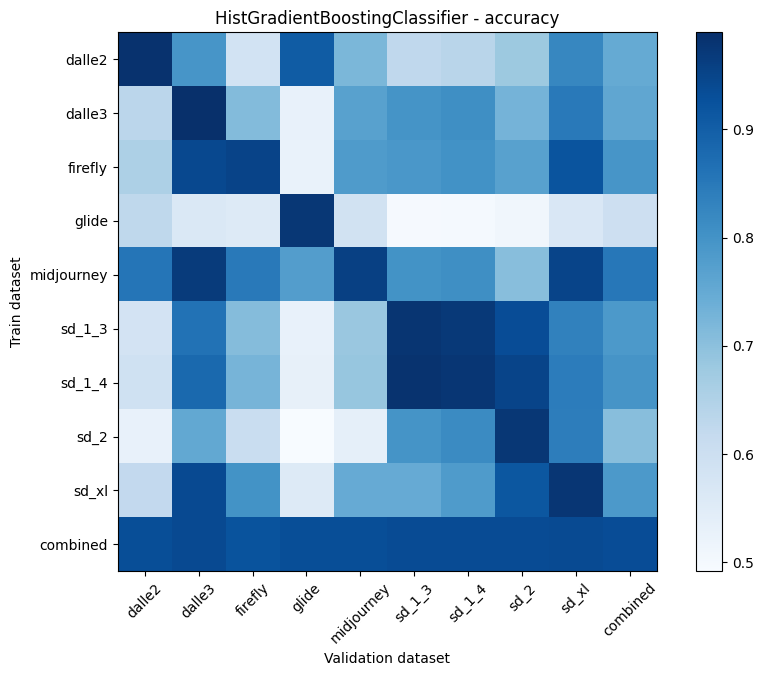

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.984375,0.794792,0.584375,0.904167,0.719792,0.625000,0.637500,0.680208,0.822917,0.750347
dalle3,0.633333,0.989583,0.710417,0.529167,0.768750,0.798958,0.808333,0.728125,0.847917,0.757176
firefly,0.654167,0.942708,0.952083,0.526042,0.783333,0.789583,0.802083,0.769792,0.919792,0.793287
glide,0.627083,0.564583,0.555208,0.975000,0.588542,0.496875,0.498958,0.507292,0.566667,0.597801
midjourney,0.857292,0.966667,0.847917,0.776042,0.958333,0.800000,0.807292,0.705208,0.950000,0.852083
sd_1_3,0.581250,0.861458,0.708333,0.528125,0.683333,0.978125,0.971875,0.933333,0.833333,0.786574
sd_1_4,0.591667,0.880208,0.726042,0.531250,0.687500,0.982292,0.976042,0.950000,0.842708,0.796412
sd_2,0.527083,0.753125,0.608333,0.491667,0.535417,0.798958,0.814583,0.975000,0.841667,0.705093
sd_xl,0.620833,0.939583,0.800000,0.557292,0.746875,0.746875,0.782292,0.914583,0.976042,0.787153


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.984375,0.794792,0.584375,0.904167,0.719792,0.625000,0.637500,0.680208,0.822917,0.750347
dalle3,0.633333,0.989583,0.710417,0.529167,0.768750,0.798958,0.808333,0.728125,0.847917,0.757176
firefly,0.654167,0.942708,0.952083,0.526042,0.783333,0.789583,0.802083,0.769792,0.919792,0.793287
glide,0.627083,0.564583,0.555208,0.975000,0.588542,0.496875,0.498958,0.507292,0.566667,0.597801
midjourney,0.857292,0.966667,0.847917,0.776042,0.958333,0.800000,0.807292,0.705208,0.950000,0.852083
sd_1_3,0.581250,0.861458,0.708333,0.528125,0.683333,0.978125,0.971875,0.933333,0.833333,0.786574
sd_1_4,0.591667,0.880208,0.726042,0.531250,0.687500,0.982292,0.976042,0.950000,0.842708,0.796412
sd_2,0.527083,0.753125,0.608333,0.491667,0.535417,0.798958,0.814583,0.975000,0.841667,0.705093
sd_xl,0.620833,0.939583,0.800000,0.557292,0.746875,0.746875,0.782292,0.914583,0.976042,0.787153


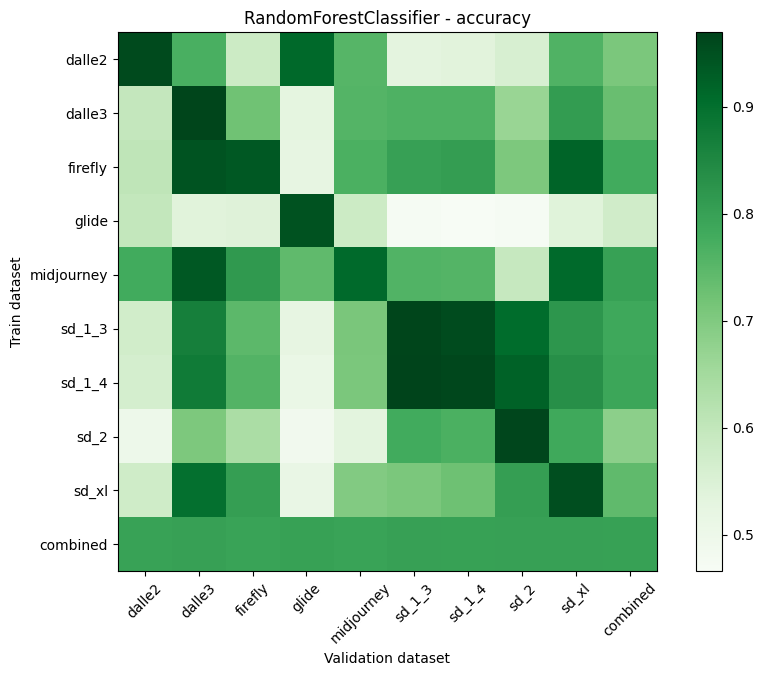

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.958333,0.770833,0.581250,0.912500,0.754167,0.530208,0.535417,0.556250,0.761458,0.706713
dalle3,0.595833,0.966667,0.722917,0.527083,0.755208,0.764583,0.764583,0.665625,0.809375,0.730208
firefly,0.604167,0.945833,0.937500,0.521875,0.768750,0.802083,0.807292,0.705208,0.919792,0.779167
glide,0.598958,0.537500,0.541667,0.946875,0.580208,0.470833,0.465625,0.469792,0.538542,0.572222
midjourney,0.779167,0.936458,0.814583,0.741667,0.909375,0.760417,0.756250,0.592708,0.910417,0.800116
sd_1_3,0.570833,0.866667,0.745833,0.520833,0.708333,0.967708,0.957292,0.905208,0.821875,0.784954
sd_1_4,0.563542,0.877083,0.758333,0.510417,0.706250,0.969792,0.962500,0.920833,0.835417,0.789352
sd_2,0.498958,0.705208,0.638542,0.485417,0.531250,0.780208,0.768750,0.964583,0.784375,0.684144
sd_xl,0.573958,0.897917,0.805208,0.513542,0.696875,0.707292,0.725000,0.805208,0.952083,0.741898


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.958333,0.770833,0.581250,0.912500,0.754167,0.530208,0.535417,0.556250,0.761458,0.706713
dalle3,0.595833,0.966667,0.722917,0.527083,0.755208,0.764583,0.764583,0.665625,0.809375,0.730208
firefly,0.604167,0.945833,0.937500,0.521875,0.768750,0.802083,0.807292,0.705208,0.919792,0.779167
glide,0.598958,0.537500,0.541667,0.946875,0.580208,0.470833,0.465625,0.469792,0.538542,0.572222
midjourney,0.779167,0.936458,0.814583,0.741667,0.909375,0.760417,0.756250,0.592708,0.910417,0.800116
sd_1_3,0.570833,0.866667,0.745833,0.520833,0.708333,0.967708,0.957292,0.905208,0.821875,0.784954
sd_1_4,0.563542,0.877083,0.758333,0.510417,0.706250,0.969792,0.962500,0.920833,0.835417,0.789352
sd_2,0.498958,0.705208,0.638542,0.485417,0.531250,0.780208,0.768750,0.964583,0.784375,0.684144
sd_xl,0.573958,0.897917,0.805208,0.513542,0.696875,0.707292,0.725000,0.805208,0.952083,0.741898


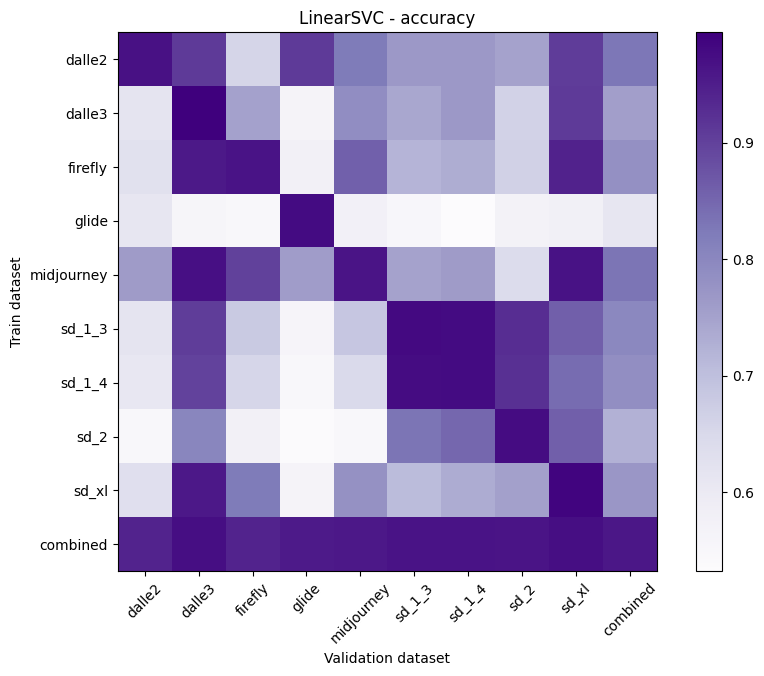

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.967708,0.909375,0.658333,0.909375,0.822917,0.765625,0.765625,0.750000,0.907292,0.828472
dalle3,0.616667,0.994792,0.752083,0.563542,0.788542,0.740625,0.765625,0.663542,0.909375,0.754977
firefly,0.627083,0.955208,0.965625,0.577083,0.858333,0.719792,0.732292,0.664583,0.942708,0.782523
glide,0.610417,0.557292,0.546875,0.977083,0.573958,0.551042,0.532292,0.568750,0.579167,0.610764
midjourney,0.761458,0.970833,0.900000,0.758333,0.963542,0.750000,0.761458,0.641667,0.966667,0.830440
sd_1_3,0.616667,0.906250,0.680208,0.558333,0.687500,0.980208,0.978125,0.927083,0.860417,0.799421
sd_1_4,0.607292,0.897917,0.655208,0.548958,0.646875,0.975000,0.977083,0.922917,0.842708,0.785995
sd_2,0.546875,0.802083,0.577083,0.536458,0.547917,0.831250,0.848958,0.976042,0.859375,0.725116
sd_xl,0.630208,0.958333,0.822917,0.563542,0.781250,0.706250,0.733333,0.753125,0.986458,0.770602


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.967708,0.909375,0.658333,0.909375,0.822917,0.765625,0.765625,0.750000,0.907292,0.828472
dalle3,0.616667,0.994792,0.752083,0.563542,0.788542,0.740625,0.765625,0.663542,0.909375,0.754977
firefly,0.627083,0.955208,0.965625,0.577083,0.858333,0.719792,0.732292,0.664583,0.942708,0.782523
glide,0.610417,0.557292,0.546875,0.977083,0.573958,0.551042,0.532292,0.568750,0.579167,0.610764
midjourney,0.761458,0.970833,0.900000,0.758333,0.963542,0.750000,0.761458,0.641667,0.966667,0.830440
sd_1_3,0.616667,0.906250,0.680208,0.558333,0.687500,0.980208,0.978125,0.927083,0.860417,0.799421
sd_1_4,0.607292,0.897917,0.655208,0.548958,0.646875,0.975000,0.977083,0.922917,0.842708,0.785995
sd_2,0.546875,0.802083,0.577083,0.536458,0.547917,0.831250,0.848958,0.976042,0.859375,0.725116
sd_xl,0.630208,0.958333,0.822917,0.563542,0.781250,0.706250,0.733333,0.753125,0.986458,0.770602


In [14]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

metric = "accuracy"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

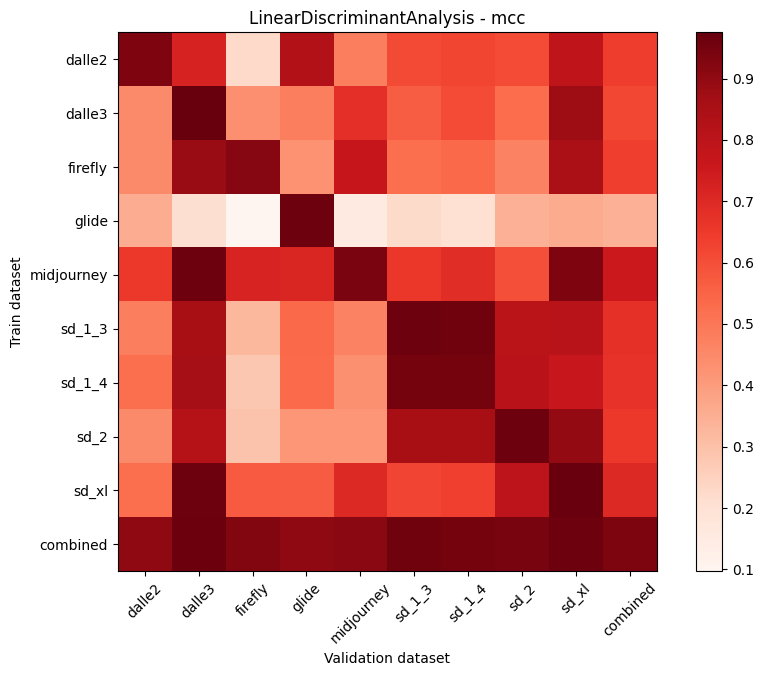

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.931387,0.718832,0.224949,0.824475,0.477741,0.608927,0.619204,0.605507,0.788374,0.642342
dalle3,0.448476,0.975293,0.434738,0.480672,0.682458,0.565473,0.606897,0.529049,0.875620,0.616506
firefly,0.448342,0.883317,0.917261,0.423517,0.768040,0.521606,0.537202,0.465914,0.846344,0.638399
glide,0.352386,0.207305,0.096890,0.958356,0.154756,0.222241,0.202178,0.342948,0.359850,0.341892
midjourney,0.655450,0.958983,0.716646,0.709557,0.939725,0.657175,0.688447,0.597357,0.931281,0.755571
sd_1_3,0.476030,0.857272,0.323440,0.536567,0.465824,0.960652,0.956401,0.802394,0.809823,0.679122
sd_1_4,0.520458,0.861654,0.282018,0.535758,0.432620,0.950638,0.950638,0.805349,0.764219,0.670323
sd_2,0.450184,0.815004,0.291492,0.415625,0.413873,0.852531,0.858260,0.958356,0.895224,0.654249
sd_xl,0.525731,0.958356,0.573746,0.567127,0.699551,0.623541,0.635233,0.796646,0.971032,0.698788


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.931387,0.718832,0.224949,0.824475,0.477741,0.608927,0.619204,0.605507,0.788374,0.644377
dalle3,0.448476,0.975293,0.434738,0.480672,0.682458,0.565473,0.606897,0.529049,0.875620,0.622075
firefly,0.448342,0.883317,0.917261,0.423517,0.768040,0.521606,0.537202,0.465914,0.846344,0.645727
glide,0.352386,0.207305,0.096890,0.958356,0.154756,0.222241,0.202178,0.342948,0.359850,0.321879
midjourney,0.655450,0.958983,0.716646,0.709557,0.939725,0.657175,0.688447,0.597357,0.931281,0.761625
sd_1_3,0.476030,0.857272,0.323440,0.536567,0.465824,0.960652,0.956401,0.802394,0.809823,0.687600
sd_1_4,0.520458,0.861654,0.282018,0.535758,0.432620,0.950638,0.950638,0.805349,0.764219,0.678150
sd_2,0.450184,0.815004,0.291492,0.415625,0.413873,0.852531,0.858260,0.958356,0.895224,0.661172
sd_xl,0.525731,0.958356,0.573746,0.567127,0.699551,0.623541,0.635233,0.796646,0.971032,0.705663


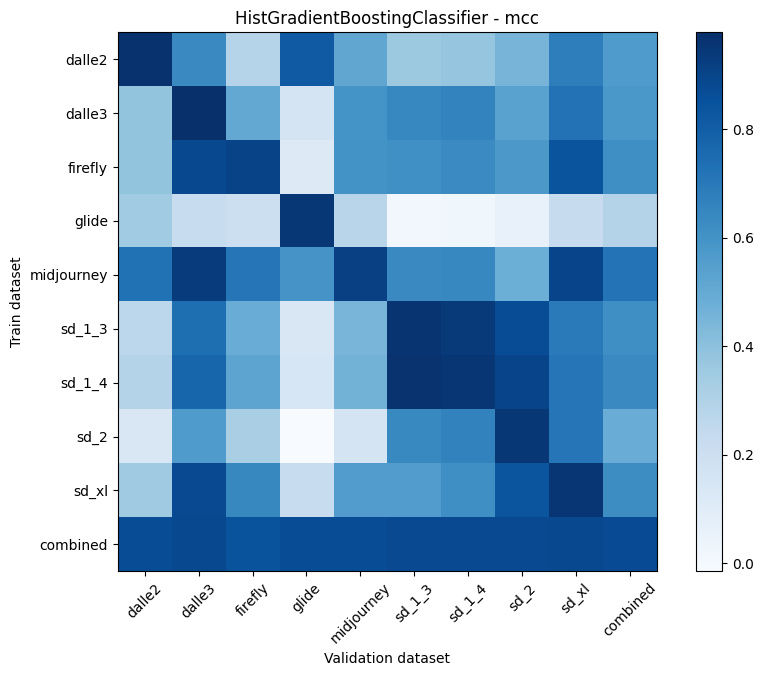

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.968843,0.634670,0.281203,0.817361,0.515592,0.358156,0.380161,0.451886,0.680020,0.564050
dalle3,0.381235,0.979195,0.507060,0.159648,0.598369,0.645877,0.660749,0.534866,0.724579,0.580269
firefly,0.384249,0.885425,0.904207,0.111064,0.600702,0.611110,0.632020,0.578231,0.840803,0.617292
glide,0.346882,0.221623,0.199745,0.950379,0.273033,0.012816,0.022475,0.057421,0.226330,0.291583
midjourney,0.730253,0.933439,0.714162,0.594601,0.916654,0.633883,0.645928,0.479093,0.900130,0.721295
sd_1_3,0.263846,0.740087,0.489809,0.133461,0.448847,0.956482,0.943785,0.868687,0.692642,0.615969
sd_1_4,0.289239,0.773681,0.521225,0.147005,0.458859,0.964821,0.952121,0.900818,0.709930,0.634013
sd_2,0.134489,0.564549,0.321504,-0.014921,0.158975,0.638131,0.663529,0.950020,0.708193,0.487497
sd_xl,0.350681,0.881741,0.643014,0.222267,0.558552,0.558552,0.614720,0.835945,0.952079,0.622467


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.968843,0.634670,0.281203,0.817361,0.515592,0.358156,0.380161,0.451886,0.680020,0.565321
dalle3,0.381235,0.979195,0.507060,0.159648,0.598369,0.645877,0.660749,0.534866,0.724579,0.576842
firefly,0.384249,0.885425,0.904207,0.111064,0.600702,0.611110,0.632020,0.578231,0.840803,0.616423
glide,0.346882,0.221623,0.199745,0.950379,0.273033,0.012816,0.022475,0.057421,0.226330,0.256745
midjourney,0.730253,0.933439,0.714162,0.594601,0.916654,0.633883,0.645928,0.479093,0.900130,0.727571
sd_1_3,0.263846,0.740087,0.489809,0.133461,0.448847,0.956482,0.943785,0.868687,0.692642,0.615294
sd_1_4,0.289239,0.773681,0.521225,0.147005,0.458859,0.964821,0.952121,0.900818,0.709930,0.635300
sd_2,0.134489,0.564549,0.321504,-0.014921,0.158975,0.638131,0.663529,0.950020,0.708193,0.458274
sd_xl,0.350681,0.881741,0.643014,0.222267,0.558552,0.558552,0.614720,0.835945,0.952079,0.624172


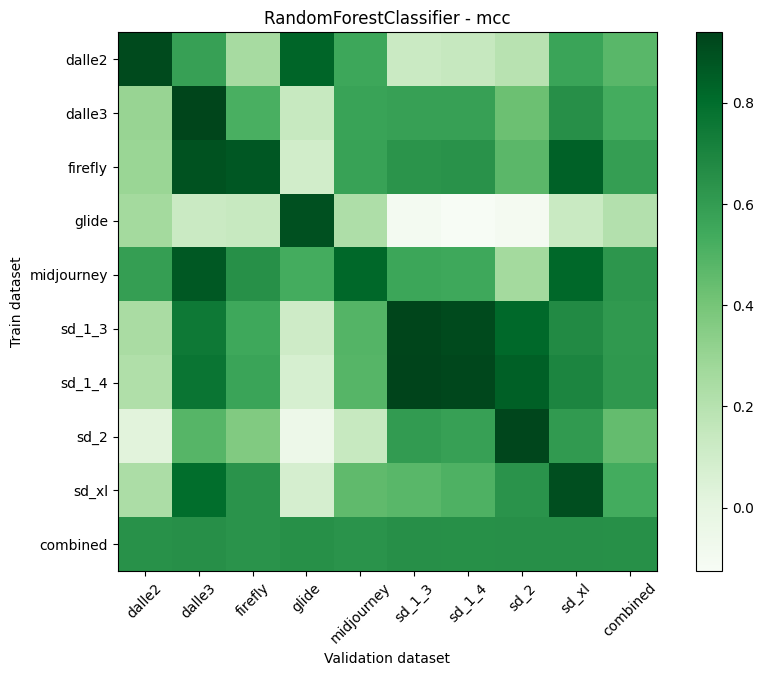

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.916764,0.581940,0.249112,0.827463,0.554520,0.125891,0.140438,0.193362,0.566507,0.476311
dalle3,0.299586,0.933406,0.517639,0.136746,0.569147,0.584092,0.584092,0.424334,0.656038,0.529294
firefly,0.292251,0.891650,0.875128,0.098609,0.576507,0.632020,0.640774,0.471294,0.840803,0.593777
glide,0.262971,0.126596,0.137054,0.895292,0.224644,-0.099362,-0.126178,-0.104527,0.129233,0.207606
midjourney,0.590141,0.872902,0.650077,0.527500,0.820146,0.558771,0.551818,0.263478,0.822132,0.625451
sd_1_3,0.241567,0.749019,0.550328,0.110512,0.489809,0.935407,0.914751,0.816855,0.673640,0.613346
sd_1_4,0.221194,0.765866,0.568053,0.070648,0.483569,0.939663,0.924988,0.844740,0.694492,0.618389
sd_2,0.023120,0.481864,0.369153,-0.051693,0.138825,0.603505,0.584914,0.929160,0.610281,0.447131
sd_xl,0.233519,0.800411,0.638946,0.074259,0.459926,0.477272,0.506556,0.638946,0.904155,0.534360


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.916764,0.581940,0.249112,0.827463,0.554520,0.125891,0.140438,0.193362,0.566507,0.461778
dalle3,0.299586,0.933406,0.517639,0.136746,0.569147,0.584092,0.584092,0.424334,0.656038,0.522787
firefly,0.292251,0.891650,0.875128,0.098609,0.576507,0.632020,0.640774,0.471294,0.840803,0.591004
glide,0.262971,0.126596,0.137054,0.895292,0.224644,-0.099362,-0.126178,-0.104527,0.129233,0.160636
midjourney,0.590141,0.872902,0.650077,0.527500,0.820146,0.558771,0.551818,0.263478,0.822132,0.628552
sd_1_3,0.241567,0.749019,0.550328,0.110512,0.489809,0.935407,0.914751,0.816855,0.673640,0.609098
sd_1_4,0.221194,0.765866,0.568053,0.070648,0.483569,0.939663,0.924988,0.844740,0.694492,0.612579
sd_2,0.023120,0.481864,0.369153,-0.051693,0.138825,0.603505,0.584914,0.929160,0.610281,0.409903
sd_xl,0.233519,0.800411,0.638946,0.074259,0.459926,0.477272,0.506556,0.638946,0.904155,0.525999


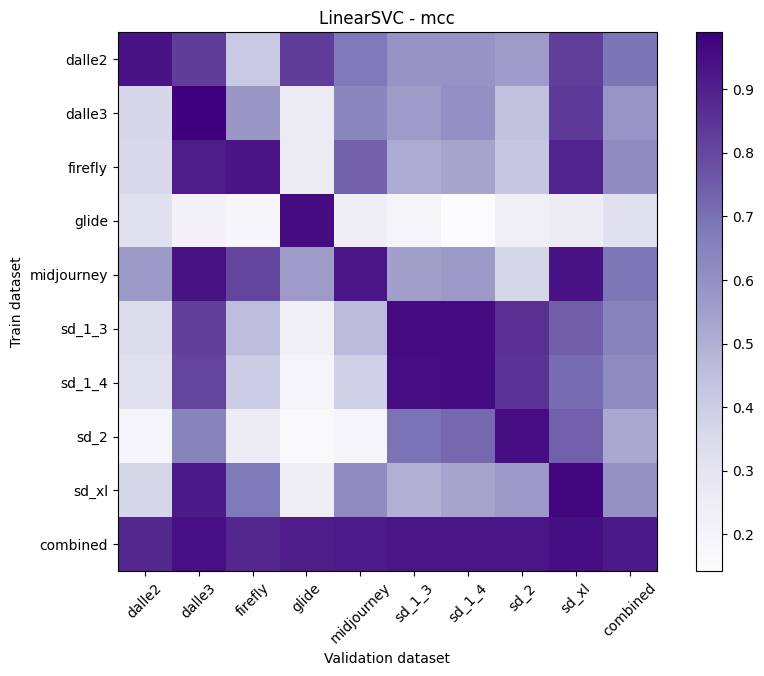

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.935518,0.826144,0.413873,0.826144,0.679055,0.586991,0.586991,0.562164,0.822420,0.688140
dalle3,0.361709,0.989584,0.578190,0.259735,0.634499,0.560554,0.599050,0.440073,0.830974,0.582644
firefly,0.359850,0.911161,0.931419,0.263788,0.737696,0.514102,0.534023,0.424348,0.887341,0.613917
glide,0.317768,0.206658,0.181124,0.954549,0.244345,0.191553,0.141830,0.232924,0.255486,0.318424
midjourney,0.568638,0.942157,0.804965,0.563526,0.927218,0.549902,0.568638,0.368151,0.933594,0.682988
sd_1_3,0.345259,0.821566,0.453618,0.227264,0.465450,0.960412,0.956246,0.858996,0.742747,0.643189
sd_1_4,0.317543,0.804247,0.403274,0.192613,0.388953,0.950059,0.954283,0.849556,0.709118,0.616114
sd_2,0.191913,0.644231,0.261510,0.164207,0.194552,0.691792,0.721183,0.952091,0.738696,0.521156
sd_xl,0.369436,0.917493,0.681002,0.239186,0.614259,0.495563,0.538544,0.569788,0.973011,0.597393


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.935518,0.826144,0.413873,0.826144,0.679055,0.586991,0.586991,0.562164,0.822420,0.693256
dalle3,0.361709,0.989584,0.578190,0.259735,0.634499,0.560554,0.599050,0.440073,0.830974,0.583818
firefly,0.359850,0.911161,0.931419,0.263788,0.737696,0.514102,0.534023,0.424348,0.887341,0.618192
glide,0.317768,0.206658,0.181124,0.954549,0.244345,0.191553,0.141830,0.232924,0.255486,0.302915
midjourney,0.568638,0.942157,0.804965,0.563526,0.927218,0.549902,0.568638,0.368151,0.933594,0.691866
sd_1_3,0.345259,0.821566,0.453618,0.227264,0.465450,0.960412,0.956246,0.858996,0.742747,0.647951
sd_1_4,0.317543,0.804247,0.403274,0.192613,0.388953,0.950059,0.954283,0.849556,0.709118,0.618850
sd_2,0.191913,0.644231,0.261510,0.164207,0.194552,0.691792,0.721183,0.952091,0.738696,0.506686
sd_xl,0.369436,0.917493,0.681002,0.239186,0.614259,0.495563,0.538544,0.569788,0.973011,0.599809


In [15]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

### Test data

In [16]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nValidation set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print() 
            # leave only the columns that are in the training set
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9752
Recall: 0.9750
MCC: 0.9502

Model: LinearDiscriminantAnalysis
Accuracy: 0.9700
F1: 0.9700
Precision: 0.9705
Recall: 0.9700
MCC: 0.9405

Model: RandomForestClassifier
Accuracy: 0.9533
F1: 0.9533
Precision: 0.9536
Recall: 0.9533
MCC: 0.9069

Model: LinearSVC
Accuracy: 0.9533
F1: 0.9533
Precision: 0.9533
Recall: 0.9533
MCC: 0.9066


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7817
F1: 0.7750
Precision: 0.8255
Recall: 0.7817
MCC: 0.6070

Model: LinearDiscriminantAnalysis
Accuracy: 0.8400
F1: 0.8383
Precision: 0.8590
Recall: 0.8400
MCC: 0.6993

Model: RandomForestClassifier
Accuracy: 0.7583
F1: 0.7510
Precision: 0.7989
Recall: 0.7583
MCC: 0.5573

Model: LinearSVC
Accuracy: 0.9033
F1: 0.9032
Precision: 0.9070
Recall: 0.9033
MCC: 0.8105


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

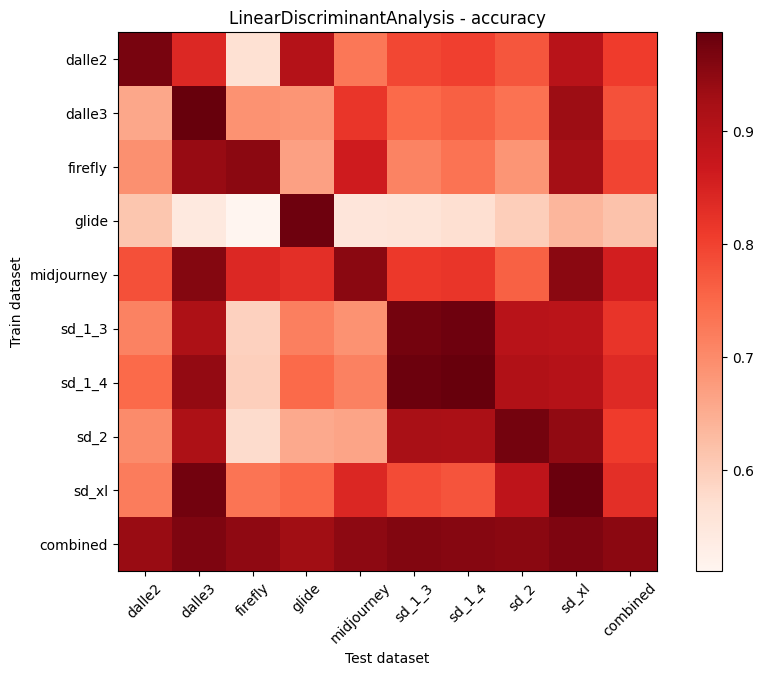

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.970000,0.840000,0.568333,0.902500,0.729167,0.793333,0.802500,0.774167,0.896667,0.808519
dalle3,0.658333,0.987500,0.688333,0.685000,0.817500,0.749167,0.760833,0.737500,0.934167,0.779815
firefly,0.691667,0.940000,0.951667,0.668333,0.861667,0.710833,0.735000,0.684167,0.926667,0.796667
glide,0.612500,0.545000,0.510833,0.978333,0.554167,0.559167,0.569167,0.599167,0.635833,0.618241
midjourney,0.781667,0.959167,0.840000,0.827500,0.952500,0.814167,0.816667,0.760000,0.953333,0.856111
sd_1_3,0.712500,0.913333,0.593333,0.717500,0.688333,0.973333,0.979167,0.896667,0.893333,0.818611
sd_1_4,0.747500,0.944167,0.597500,0.747500,0.715000,0.980833,0.985833,0.907500,0.901667,0.836389
sd_2,0.699167,0.913333,0.576667,0.655000,0.662500,0.919167,0.918333,0.973333,0.945000,0.806944
sd_xl,0.722500,0.975000,0.732500,0.752500,0.840833,0.786667,0.776667,0.888333,0.982500,0.828611


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.970000,0.840000,0.568333,0.902500,0.729167,0.793333,0.802500,0.774167,0.896667,0.808519
dalle3,0.658333,0.987500,0.688333,0.685000,0.817500,0.749167,0.760833,0.737500,0.934167,0.779815
firefly,0.691667,0.940000,0.951667,0.668333,0.861667,0.710833,0.735000,0.684167,0.926667,0.796667
glide,0.612500,0.545000,0.510833,0.978333,0.554167,0.559167,0.569167,0.599167,0.635833,0.618241
midjourney,0.781667,0.959167,0.840000,0.827500,0.952500,0.814167,0.816667,0.760000,0.953333,0.856111
sd_1_3,0.712500,0.913333,0.593333,0.717500,0.688333,0.973333,0.979167,0.896667,0.893333,0.818611
sd_1_4,0.747500,0.944167,0.597500,0.747500,0.715000,0.980833,0.985833,0.907500,0.901667,0.836389
sd_2,0.699167,0.913333,0.576667,0.655000,0.662500,0.919167,0.918333,0.973333,0.945000,0.806944
sd_xl,0.722500,0.975000,0.732500,0.752500,0.840833,0.786667,0.776667,0.888333,0.982500,0.828611


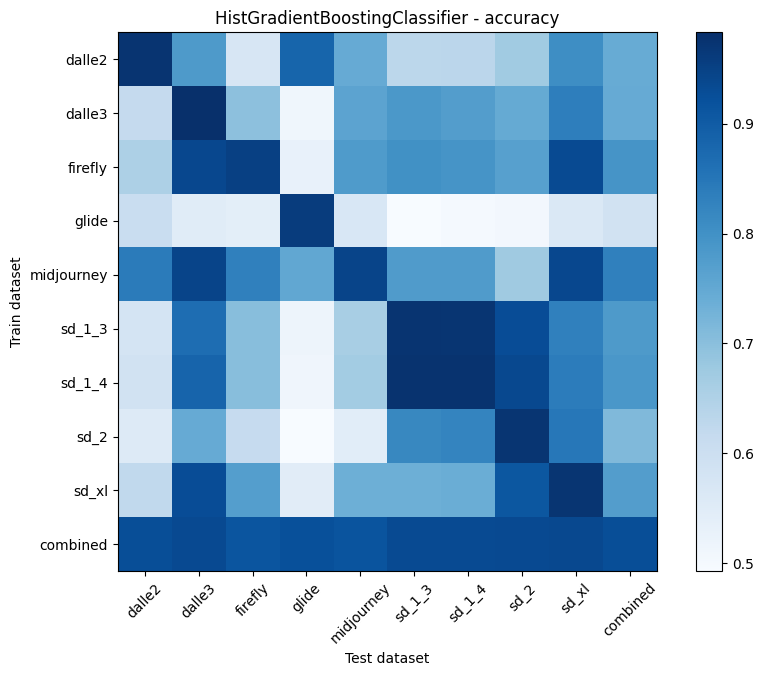

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.975000,0.781667,0.570000,0.882500,0.744167,0.629167,0.631667,0.671667,0.805833,0.743519
dalle3,0.616667,0.983333,0.696667,0.510000,0.760833,0.785833,0.773333,0.745833,0.834167,0.745185
firefly,0.651667,0.937500,0.952500,0.527500,0.778333,0.800833,0.791667,0.768333,0.932500,0.793426
glide,0.605833,0.548333,0.541667,0.960000,0.569167,0.492500,0.500000,0.505833,0.563333,0.587407
midjourney,0.840833,0.944167,0.831667,0.751667,0.944167,0.777500,0.777500,0.674167,0.939167,0.831204
sd_1_3,0.578333,0.866667,0.702500,0.516667,0.660000,0.974167,0.972500,0.928333,0.830833,0.781111
sd_1_4,0.585000,0.884167,0.702500,0.513333,0.668333,0.975833,0.975833,0.935833,0.839167,0.786667
sd_2,0.555000,0.744167,0.613333,0.494167,0.545833,0.817500,0.824167,0.972500,0.847500,0.712685
sd_xl,0.621667,0.929167,0.770833,0.546667,0.735000,0.735000,0.738333,0.910000,0.972500,0.773241


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.975000,0.781667,0.570000,0.882500,0.744167,0.629167,0.631667,0.671667,0.805833,0.743519
dalle3,0.616667,0.983333,0.696667,0.510000,0.760833,0.785833,0.773333,0.745833,0.834167,0.745185
firefly,0.651667,0.937500,0.952500,0.527500,0.778333,0.800833,0.791667,0.768333,0.932500,0.793426
glide,0.605833,0.548333,0.541667,0.960000,0.569167,0.492500,0.500000,0.505833,0.563333,0.587407
midjourney,0.840833,0.944167,0.831667,0.751667,0.944167,0.777500,0.777500,0.674167,0.939167,0.831204
sd_1_3,0.578333,0.866667,0.702500,0.516667,0.660000,0.974167,0.972500,0.928333,0.830833,0.781111
sd_1_4,0.585000,0.884167,0.702500,0.513333,0.668333,0.975833,0.975833,0.935833,0.839167,0.786667
sd_2,0.555000,0.744167,0.613333,0.494167,0.545833,0.817500,0.824167,0.972500,0.847500,0.712685
sd_xl,0.621667,0.929167,0.770833,0.546667,0.735000,0.735000,0.738333,0.910000,0.972500,0.773241


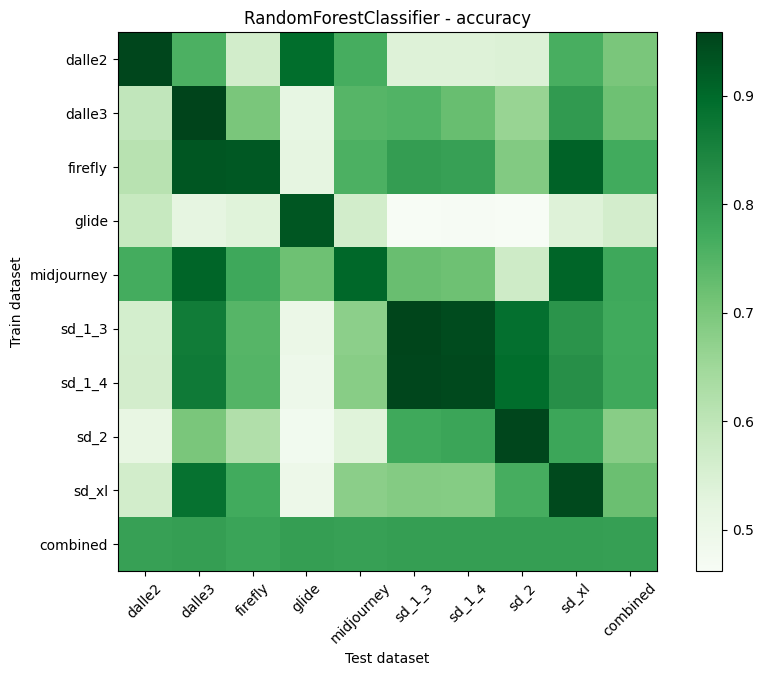

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.953333,0.758333,0.564167,0.892500,0.765833,0.538333,0.537500,0.542500,0.764167,0.701852
dalle3,0.594167,0.958333,0.700833,0.515000,0.745833,0.750833,0.724167,0.660833,0.803333,0.717037
firefly,0.610000,0.930000,0.926667,0.519167,0.758333,0.799167,0.793333,0.690000,0.910000,0.770741
glide,0.585000,0.520000,0.535000,0.930833,0.564167,0.461667,0.465000,0.461667,0.537500,0.562315
midjourney,0.766667,0.907500,0.777500,0.715833,0.902500,0.723333,0.716667,0.570833,0.907500,0.776481
sd_1_3,0.559167,0.864167,0.746667,0.501667,0.675833,0.955833,0.946667,0.886667,0.815833,0.772500
sd_1_4,0.561667,0.868333,0.748333,0.493333,0.681667,0.953333,0.950000,0.894167,0.825000,0.775093
sd_2,0.513333,0.701667,0.622500,0.480000,0.535000,0.774167,0.782500,0.953333,0.780833,0.682593
sd_xl,0.564167,0.884167,0.771667,0.495000,0.677500,0.687500,0.686667,0.765833,0.949167,0.720185


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.953333,0.758333,0.564167,0.892500,0.765833,0.538333,0.537500,0.542500,0.764167,0.701852
dalle3,0.594167,0.958333,0.700833,0.515000,0.745833,0.750833,0.724167,0.660833,0.803333,0.717037
firefly,0.610000,0.930000,0.926667,0.519167,0.758333,0.799167,0.793333,0.690000,0.910000,0.770741
glide,0.585000,0.520000,0.535000,0.930833,0.564167,0.461667,0.465000,0.461667,0.537500,0.562315
midjourney,0.766667,0.907500,0.777500,0.715833,0.902500,0.723333,0.716667,0.570833,0.907500,0.776481
sd_1_3,0.559167,0.864167,0.746667,0.501667,0.675833,0.955833,0.946667,0.886667,0.815833,0.772500
sd_1_4,0.561667,0.868333,0.748333,0.493333,0.681667,0.953333,0.950000,0.894167,0.825000,0.775093
sd_2,0.513333,0.701667,0.622500,0.480000,0.535000,0.774167,0.782500,0.953333,0.780833,0.682593
sd_xl,0.564167,0.884167,0.771667,0.495000,0.677500,0.687500,0.686667,0.765833,0.949167,0.720185


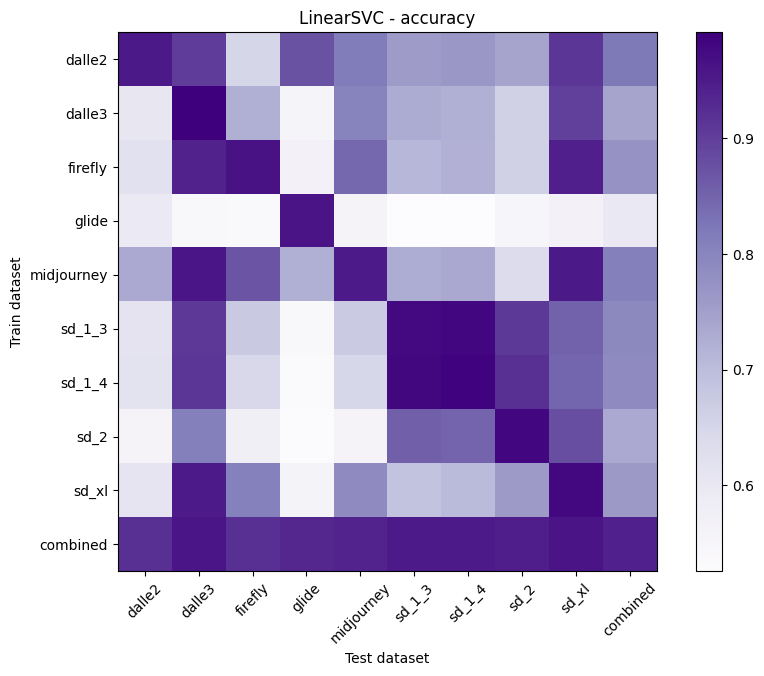

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.953333,0.903333,0.650833,0.873333,0.815833,0.756667,0.765833,0.742500,0.910000,0.819074
dalle3,0.605000,0.991667,0.724167,0.553333,0.802500,0.730000,0.724167,0.660000,0.897500,0.743148
firefly,0.620000,0.940000,0.963333,0.567500,0.843333,0.708333,0.719167,0.659167,0.944167,0.773889
glide,0.593333,0.542500,0.536667,0.960000,0.557500,0.527500,0.525833,0.550833,0.565833,0.595556
midjourney,0.731667,0.958333,0.870833,0.723333,0.950833,0.729167,0.735000,0.633333,0.953333,0.809537
sd_1_3,0.611667,0.909167,0.674167,0.540833,0.672500,0.976667,0.979167,0.907500,0.853333,0.791667
sd_1_4,0.615833,0.910833,0.645000,0.533333,0.648333,0.981667,0.986667,0.919167,0.847500,0.787593
sd_2,0.557500,0.810000,0.574167,0.529167,0.555000,0.855833,0.848333,0.979167,0.877500,0.731852
sd_xl,0.610000,0.950000,0.807500,0.560000,0.787500,0.688333,0.702500,0.757500,0.978333,0.760185


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.953333,0.903333,0.650833,0.873333,0.815833,0.756667,0.765833,0.742500,0.910000,0.819074
dalle3,0.605000,0.991667,0.724167,0.553333,0.802500,0.730000,0.724167,0.660000,0.897500,0.743148
firefly,0.620000,0.940000,0.963333,0.567500,0.843333,0.708333,0.719167,0.659167,0.944167,0.773889
glide,0.593333,0.542500,0.536667,0.960000,0.557500,0.527500,0.525833,0.550833,0.565833,0.595556
midjourney,0.731667,0.958333,0.870833,0.723333,0.950833,0.729167,0.735000,0.633333,0.953333,0.809537
sd_1_3,0.611667,0.909167,0.674167,0.540833,0.672500,0.976667,0.979167,0.907500,0.853333,0.791667
sd_1_4,0.615833,0.910833,0.645000,0.533333,0.648333,0.981667,0.986667,0.919167,0.847500,0.787593
sd_2,0.557500,0.810000,0.574167,0.529167,0.555000,0.855833,0.848333,0.979167,0.877500,0.731852
sd_xl,0.610000,0.950000,0.807500,0.560000,0.787500,0.688333,0.702500,0.757500,0.978333,0.760185


In [17]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "accuracy"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

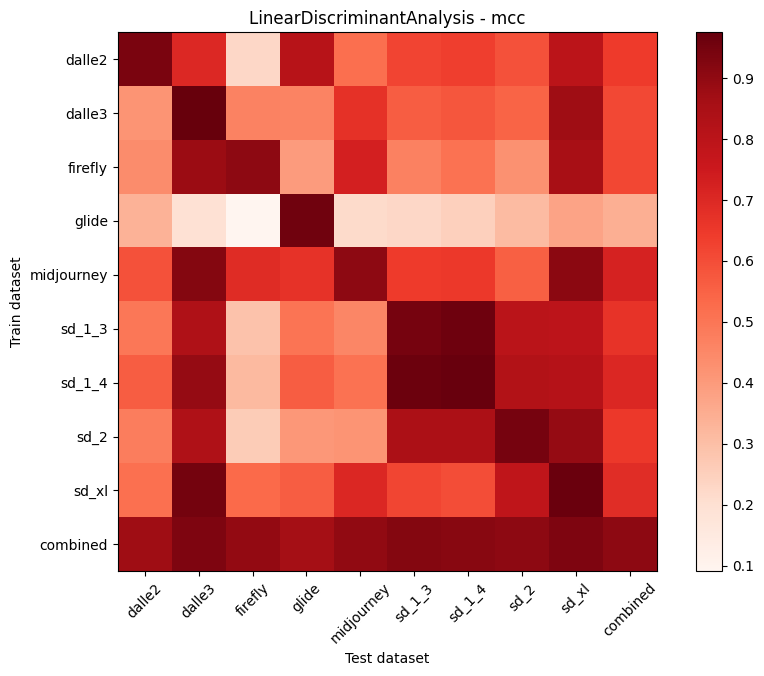

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.940467,0.699278,0.228147,0.809479,0.516482,0.621238,0.636375,0.589797,0.798822,0.646356
dalle3,0.417421,0.975211,0.466442,0.461067,0.671539,0.562929,0.581315,0.544548,0.871641,0.611309
firefly,0.438118,0.880290,0.904497,0.397977,0.729736,0.470631,0.511323,0.425297,0.853280,0.615541
glide,0.334713,0.193315,0.090780,0.956692,0.215575,0.227147,0.249292,0.309830,0.376240,0.345144
midjourney,0.591267,0.919969,0.691743,0.669825,0.905945,0.646710,0.651025,0.554785,0.907688,0.720406
sd_1_3,0.495677,0.831079,0.288817,0.503758,0.456316,0.946819,0.958777,0.800889,0.794935,0.667292
sd_1_4,0.562505,0.890728,0.313777,0.562505,0.511479,0.961654,0.971717,0.824097,0.813829,0.703739
sd_2,0.478797,0.832312,0.261616,0.406095,0.418691,0.842934,0.841411,0.946663,0.891177,0.651248
sd_xl,0.514003,0.950100,0.530027,0.562012,0.705535,0.616814,0.600722,0.786899,0.965453,0.685217


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.940467,0.699278,0.228147,0.809479,0.516482,0.621238,0.636375,0.589797,0.798822,0.648898
dalle3,0.417421,0.975211,0.466442,0.461067,0.671539,0.562929,0.581315,0.544548,0.871641,0.616901
firefly,0.438118,0.880290,0.904497,0.397977,0.729736,0.470631,0.511323,0.425297,0.853280,0.623461
glide,0.334713,0.193315,0.090780,0.956692,0.215575,0.227147,0.249292,0.309830,0.376240,0.328176
midjourney,0.591267,0.919969,0.691743,0.669825,0.905945,0.646710,0.651025,0.554785,0.907688,0.726551
sd_1_3,0.495677,0.831079,0.288817,0.503758,0.456316,0.946819,0.958777,0.800889,0.794935,0.675230
sd_1_4,0.562505,0.890728,0.313777,0.562505,0.511479,0.961654,0.971717,0.824097,0.813829,0.712477
sd_2,0.478797,0.832312,0.261616,0.406095,0.418691,0.842934,0.841411,0.946663,0.891177,0.657744
sd_xl,0.514003,0.950100,0.530027,0.562012,0.705535,0.616814,0.600722,0.786899,0.965453,0.692396


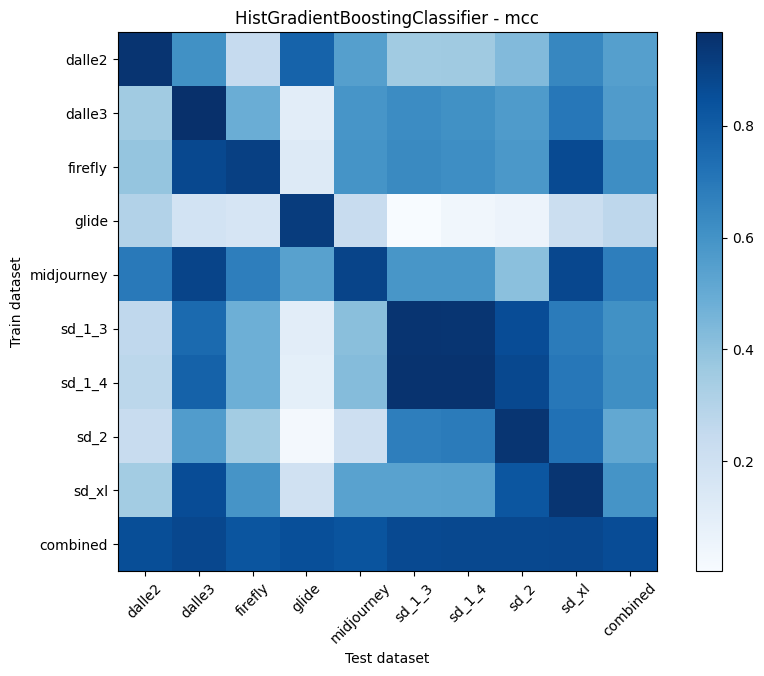

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.950221,0.607024,0.240781,0.775767,0.546671,0.355683,0.360129,0.428742,0.646305,0.545629
dalle3,0.356242,0.966681,0.487933,0.104746,0.587750,0.626662,0.607171,0.564494,0.703216,0.563489
firefly,0.384884,0.875289,0.904971,0.124699,0.595021,0.632190,0.616999,0.578608,0.865571,0.619909
glide,0.304377,0.182009,0.165367,0.920035,0.229967,0.003640,0.035472,0.057667,0.217069,0.268224
midjourney,0.692785,0.888770,0.676637,0.540069,0.888770,0.583570,0.583570,0.409021,0.878512,0.675825
sd_1_3,0.260074,0.748729,0.480615,0.103430,0.410456,0.948458,0.945073,0.859120,0.688216,0.606991
sd_1_4,0.273758,0.779136,0.480615,0.092139,0.424452,0.951855,0.951855,0.873246,0.702106,0.615959
sd_2,0.230008,0.559567,0.346610,0.021194,0.208173,0.674835,0.685519,0.945225,0.723359,0.510387
sd_xl,0.346632,0.861129,0.592287,0.191949,0.535091,0.535091,0.540411,0.825944,0.945006,0.596140


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.950221,0.607024,0.240781,0.775767,0.546671,0.355683,0.360129,0.428742,0.646305,0.545703
dalle3,0.356242,0.966681,0.487933,0.104746,0.587750,0.626662,0.607171,0.564494,0.703216,0.556100
firefly,0.384884,0.875289,0.904971,0.124699,0.595021,0.632190,0.616999,0.578608,0.865571,0.619804
glide,0.304377,0.182009,0.165367,0.920035,0.229967,0.003640,0.035472,0.057667,0.217069,0.235067
midjourney,0.692785,0.888770,0.676637,0.540069,0.888770,0.583570,0.583570,0.409021,0.878512,0.682412
sd_1_3,0.260074,0.748729,0.480615,0.103430,0.410456,0.948458,0.945073,0.859120,0.688216,0.604908
sd_1_4,0.273758,0.779136,0.480615,0.092139,0.424452,0.951855,0.951855,0.873246,0.702106,0.614351
sd_2,0.230008,0.559567,0.346610,0.021194,0.208173,0.674835,0.685519,0.945225,0.723359,0.488277
sd_xl,0.346632,0.861129,0.592287,0.191949,0.535091,0.535091,0.540411,0.825944,0.945006,0.597060


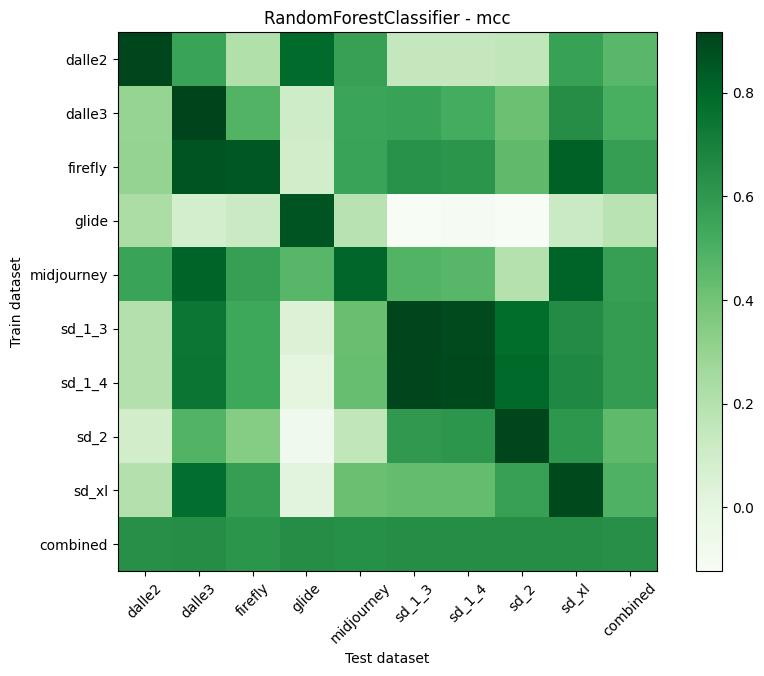

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.906913,0.557296,0.208572,0.788860,0.569722,0.147013,0.144866,0.157571,0.566959,0.463647
dalle3,0.296839,0.916924,0.481486,0.102398,0.553409,0.561365,0.518897,0.415903,0.645401,0.507505
firefly,0.301057,0.860115,0.853579,0.093255,0.556508,0.624685,0.614871,0.442774,0.821444,0.577118
glide,0.232492,0.082124,0.120952,0.862508,0.188607,-0.123845,-0.107919,-0.123845,0.127115,0.184552
midjourney,0.555374,0.814979,0.574194,0.467742,0.804927,0.480658,0.469178,0.199676,0.814979,0.572421
sd_1_3,0.202245,0.739138,0.541399,0.039415,0.424023,0.911761,0.893297,0.779366,0.655951,0.583849
sd_1_4,0.201796,0.744553,0.539931,0.005402,0.428673,0.906993,0.900169,0.791691,0.668600,0.584364
sd_2,0.092139,0.479263,0.345158,-0.073442,0.158232,0.595806,0.609231,0.906922,0.606543,0.448096
sd_xl,0.205096,0.772678,0.577201,0.011426,0.419575,0.436595,0.435182,0.567462,0.898608,0.491481


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.906913,0.557296,0.208572,0.788860,0.569722,0.147013,0.144866,0.157571,0.566959,0.449752
dalle3,0.296839,0.916924,0.481486,0.102398,0.553409,0.561365,0.518897,0.415903,0.645401,0.499180
firefly,0.301057,0.860115,0.853579,0.093255,0.556508,0.624685,0.614871,0.442774,0.821444,0.574254
glide,0.232492,0.082124,0.120952,0.862508,0.188607,-0.123845,-0.107919,-0.123845,0.127115,0.139799
midjourney,0.555374,0.814979,0.574194,0.467742,0.804927,0.480658,0.469178,0.199676,0.814979,0.575745
sd_1_3,0.202245,0.739138,0.541399,0.039415,0.424023,0.911761,0.893297,0.779366,0.655951,0.576288
sd_1_4,0.201796,0.744553,0.539931,0.005402,0.428673,0.906993,0.900169,0.791691,0.668600,0.576423
sd_2,0.092139,0.479263,0.345158,-0.073442,0.158232,0.595806,0.609231,0.906922,0.606543,0.413317
sd_xl,0.205096,0.772678,0.577201,0.011426,0.419575,0.436595,0.435182,0.567462,0.898608,0.480425


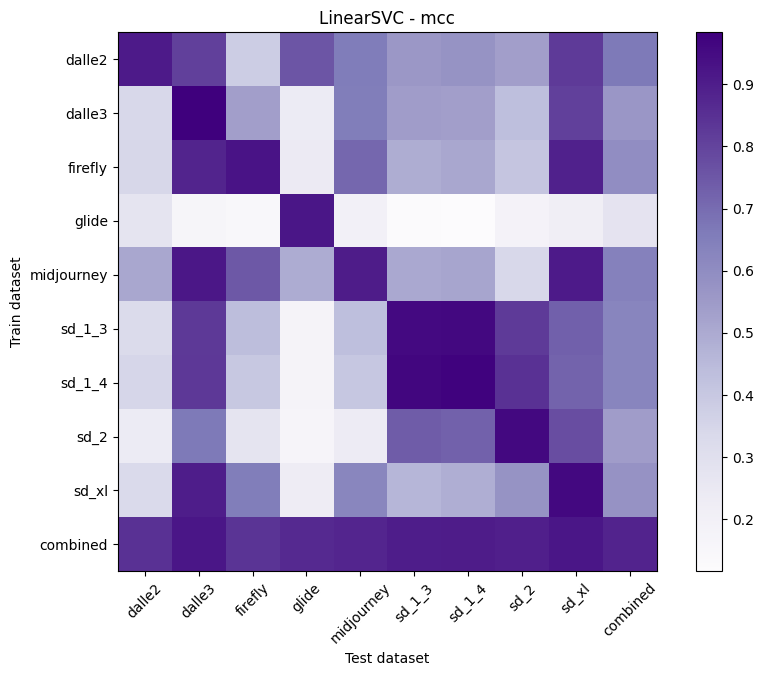

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.906644,0.810460,0.383435,0.756190,0.657227,0.559511,0.574512,0.536356,0.822835,0.662670
dalle3,0.339353,0.983332,0.533474,0.235934,0.654700,0.542477,0.533474,0.432629,0.809512,0.562745
firefly,0.342114,0.881330,0.926672,0.238623,0.709718,0.491213,0.508651,0.410383,0.889288,0.596262
glide,0.273503,0.161067,0.146101,0.920344,0.197145,0.121266,0.116554,0.181497,0.215962,0.277908
midjourney,0.508117,0.918031,0.747371,0.494170,0.902344,0.503935,0.513692,0.338879,0.907546,0.639299
sd_1_3,0.328389,0.824437,0.436738,0.177140,0.433982,0.953436,0.958528,0.821429,0.727142,0.625730
sd_1_4,0.347520,0.830003,0.398149,0.170870,0.403756,0.963324,0.973404,0.844892,0.721948,0.625522
sd_2,0.238010,0.663757,0.273855,0.166276,0.232319,0.737749,0.725442,0.958393,0.773846,0.541584
sd_xl,0.331787,0.901184,0.654598,0.230951,0.622583,0.465116,0.487871,0.575019,0.956668,0.579263


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.906644,0.810460,0.383435,0.756190,0.657227,0.559511,0.574512,0.536356,0.822835,0.667463
dalle3,0.339353,0.983332,0.533474,0.235934,0.654700,0.542477,0.533474,0.432629,0.809512,0.562765
firefly,0.342114,0.881330,0.926672,0.238623,0.709718,0.491213,0.508651,0.410383,0.889288,0.599777
glide,0.273503,0.161067,0.146101,0.920344,0.197145,0.121266,0.116554,0.181497,0.215962,0.259271
midjourney,0.508117,0.918031,0.747371,0.494170,0.902344,0.503935,0.513692,0.338879,0.907546,0.648232
sd_1_3,0.328389,0.824437,0.436738,0.177140,0.433982,0.953436,0.958528,0.821429,0.727142,0.629025
sd_1_4,0.347520,0.830003,0.398149,0.170870,0.403756,0.963324,0.973404,0.844892,0.721948,0.628207
sd_2,0.238010,0.663757,0.273855,0.166276,0.232319,0.737749,0.725442,0.958393,0.773846,0.529961
sd_xl,0.331787,0.901184,0.654598,0.230951,0.622583,0.465116,0.487871,0.575019,0.956668,0.580642


In [18]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

## Safe models and scalers

In [19]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/synthbuster/standardAugmented/{dataset_name}"
        scalers_dir_path = f"scalers/synthbuster/standardAugmented/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))